<hr>

# 🤖 MACHINE LEARNING 🤖

<style>
h1 {
    text-align: center;
    color: hotpink;
    font-weight: bold;
}
</style>

<style>
h2 {
    text-align: center;
    color: black;
    font-weight: bold;
}
</style>

<style>
h3 {
    text-align: center;
    color: black;
    font-weight: bold;
}
</style>

<style>
h4 {
    text-align: center;
    color: black;
    font-weight: bold;
}
</style>

<hr>

In [95]:
!pip install xgboost

In [96]:
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score  
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
import numpy as np
from imblearn.over_sampling import SMOTE


In [97]:
X_train = pd.read_csv("../data/processed/X_train.csv")
X_test  = pd.read_csv("../data/processed/X_test.csv")

y_train = pd.read_csv("../data/processed/y_train.csv").values.ravel()
y_test  = pd.read_csv("../data/processed/y_test.csv").values.ravel()

# 1. KNearest Neighbours model

## Fitting and prediction

In [10]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train) #fit the model to the training data
pred = knn.predict(X_test) #make predictions on the test set using the fitted model

## Results 

### Accuracy

In [11]:
knn.score(X_test, y_test)

0.8446877534468775

### Classification Report

In [12]:
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))


[[1960   95]
 [ 288  123]]
              precision    recall  f1-score   support

       False       0.87      0.95      0.91      2055
        True       0.56      0.30      0.39       411

    accuracy                           0.84      2466
   macro avg       0.72      0.63      0.65      2466
weighted avg       0.82      0.84      0.82      2466



- 288 actual buyers were predicted as non-buyers
- Only 125 buyers were correctly predicted
- Hence the precision and recall rate for minority class, TRUE, is very low.

### ROC AUC

In [13]:
# Get probability of positive / minority class (class = 1)
y_train_proba_knn = knn.predict_proba(X_train)[:, 1]
y_test_proba_knn  = knn.predict_proba(X_test)[:, 1]

# ROC-AUC
roc_auc_train_knn = roc_auc_score(y_train, y_train_proba_knn)
roc_auc_test_knn  = roc_auc_score(y_test, y_test_proba_knn)

print("ROC AUC - Train:", roc_auc_train_knn)
print("ROC AUC - Test :", roc_auc_test_knn)

ROC AUC - Train: 0.9566420598657177
ROC AUC - Test : 0.7097341360754436


### PR AUC

In [14]:
# PR-AUC
pr_auc_train_knn = average_precision_score(y_train, y_train_proba_knn)
pr_auc_test_knn  = average_precision_score(y_test, y_test_proba_knn)

print("PR AUC  - Train:", pr_auc_train_knn)
print("PR AUC  - Test :", pr_auc_test_knn)

PR AUC  - Train: 0.736040899883986
PR AUC  - Test : 0.36961170954275546


- The train and test AUC's have a huge difference.
- The model is memorising than predicting.

# 2. Logistic Regression (class weight balanced)

## Fitting and prediction

In [15]:
# Initialize model
lr= LogisticRegression(class_weight='balanced',max_iter=5000)

# Train
lr.fit(X_train, y_train)

# Predict
y_pred = lr.predict(X_test)


/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Evaluation 

### Classification Report

In [16]:
# Evaluate
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[1831  224]
 [ 102  309]]
              precision    recall  f1-score   support

       False       0.95      0.89      0.92      2055
        True       0.58      0.75      0.65       411

    accuracy                           0.87      2466
   macro avg       0.76      0.82      0.79      2466
weighted avg       0.89      0.87      0.87      2466



### ROC AUC

In [17]:
# predicted probablities
# Probability of positive class (Revenue = True)
y_train_proba = lr.predict_proba(X_train)[:, 1]
y_test_proba  = lr.predict_proba(X_test)[:, 1]

In [18]:
roc_auc_train = roc_auc_score(y_train, y_train_proba)
roc_auc_test  = roc_auc_score(y_test, y_test_proba)

print("ROC AUC - Train:", roc_auc_train)
print("ROC AUC - Test :", roc_auc_test)

ROC AUC - Train: 0.9115032582993964
ROC AUC - Test : 0.9055298038728163


### PR AUC

In [19]:
pr_auc_train = average_precision_score(y_train, y_train_proba)
pr_auc_test  = average_precision_score(y_test, y_test_proba)

print("PR AUC  - Train:", pr_auc_train)
print("PR AUC  - Test :", pr_auc_test)

PR AUC  - Train: 0.6543084453843336
PR AUC  - Test : 0.6622221876810904


- PR AUC of 0.66 is quite decent for a dataset with 15% positive class, denotes a good separation power

# 3. Random Forest

## Fitting and prediction

In [20]:
rf = RandomForestClassifier(
    n_estimators=200,
    class_weight="balanced",
    random_state=42
)
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=200,
                       random_state=42)

In [21]:
y_pred_rf = rf.predict(X_test)

# Probabilities (for AUC)
y_train_proba_rf = rf.predict_proba(X_train)[:, 1]
y_test_proba_rf  = rf.predict_proba(X_test)[:, 1]

## Evaluation 

### Accuracy

In [22]:
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("Accuracy:", accuracy_rf)


Accuracy: 0.889294403892944


### Classification Report

In [23]:
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

[[1995   60]
 [ 213  198]]
              precision    recall  f1-score   support

       False       0.90      0.97      0.94      2055
        True       0.77      0.48      0.59       411

    accuracy                           0.89      2466
   macro avg       0.84      0.73      0.76      2466
weighted avg       0.88      0.89      0.88      2466



### ROC AUC

In [24]:
roc_train_rf = roc_auc_score(y_train, y_train_proba_rf)
roc_test_rf = roc_auc_score(y_test, y_test_proba_rf)
print("ROC AUC (Train):", roc_train_rf)
print("ROC AUC (Test):", roc_test_rf)

ROC AUC (Train): 1.0
ROC AUC (Test): 0.920917470296766


### PR AUC

In [25]:
pr_train_rf = average_precision_score(y_train, y_train_proba_rf)
pr_test_rf = average_precision_score(y_test, y_test_proba_rf)
print("PR AUC (Train):", pr_train_rf)
print("PR AUC (Test):", pr_test_rf)

PR AUC (Train): 1.0
PR AUC (Test): 0.7308958464033524


- Random Forest model is overfitting but the test performance and PR AUC is higher

### PR curve 

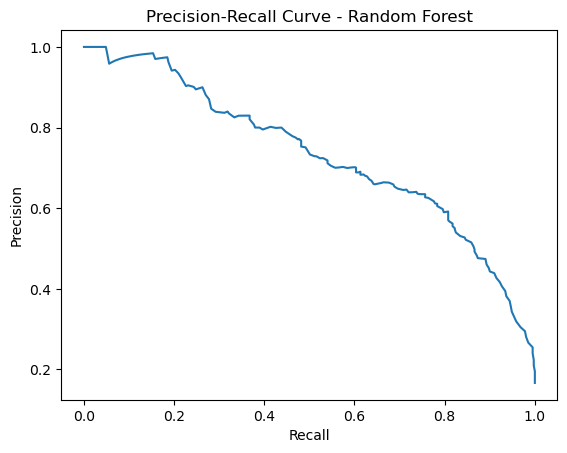

In [26]:
precision, recall, thresholds = precision_recall_curve(y_test, y_test_proba_rf)

plt.figure()
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - Random Forest")
plt.show()

- X-Axis - **Recall** - How many actual buyers does the model catch?
- Y-Axis - **Precision** - How accurate the buyer predictions were?

- Very high precision at low recall --> targeting top few high probability users, they all convert. This can be used for expensive discounts and when we have limited budget campaign since accuracy / precision is high. 

- At high recall, the precision drops --> so if the model tries to catch all buyers, we also target many non-buyers (low precision / accuracy)

### Feature importance

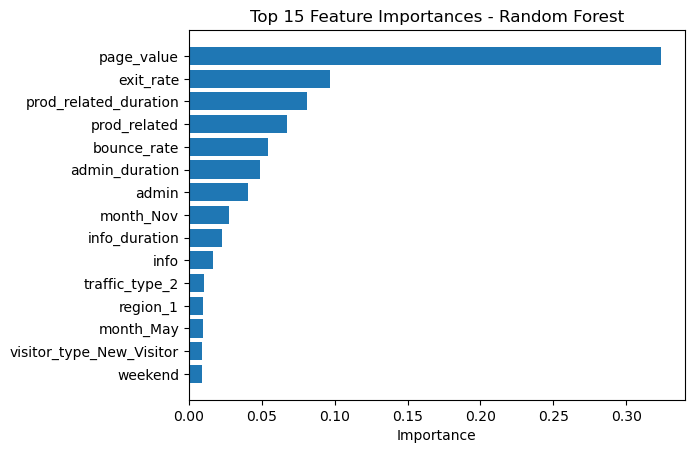

In [27]:
# Get feature importance
importances = rf.feature_importances_

# Create dataframe
feature_importance = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": importances
})

# Sort descending
feature_importance = feature_importance.sort_values(by="Importance", ascending=False)

# Plot top 15
plt.figure()
plt.barh(feature_importance["Feature"][:15], feature_importance["Importance"][:15])
plt.gca().invert_yaxis()
plt.title("Top 15 Feature Importances - Random Forest")
plt.xlabel("Importance")
plt.show()

- High-importance features such as Page Value and Exit Rate are strong behavioral signals of purchase intent, but manipulating these need not affect conversions necessarily. 
- Feature importnace != Causality

# 4. XGBoost model

## Fitting and Prediction

In [28]:
# Calculate imbalance ratio
neg = np.sum(y_train == 0)
pos = np.sum(y_train == 1)
scale_pos_weight = neg / pos

xgb = XGBClassifier(
    n_estimators=300, #learning rate (0.05, dataset is ~12k rows)
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    use_label_encoder=False,
    eval_metric="logloss"
)

xgb.fit(X_train, y_train)

/opt/anaconda3/lib/python3.13/site-packages/xgboost/training.py:200: UserWarning: [23:36:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, ...)

In [29]:
y_pred_xgb = xgb.predict(X_test)

y_train_proba_xgb = xgb.predict_proba(X_train)[:, 1]
y_test_proba_xgb  = xgb.predict_proba(X_test)[:, 1]

## Evaluation

### Accuracy

In [30]:
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print("Accuracy (Test):", accuracy_xgb)

Accuracy (Test): 0.8714517437145174


### Classification Report

In [31]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred_xgb = xgb.predict(X_test)

print(confusion_matrix(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))

[[1814  241]
 [  76  335]]
              precision    recall  f1-score   support

       False       0.96      0.88      0.92      2055
        True       0.58      0.82      0.68       411

    accuracy                           0.87      2466
   macro avg       0.77      0.85      0.80      2466
weighted avg       0.90      0.87      0.88      2466



### ROC AUC

In [32]:
y_train_proba_xgb = xgb.predict_proba(X_train)[:, 1]
y_test_proba_xgb  = xgb.predict_proba(X_test)[:, 1]

roc_train_xgb = roc_auc_score(y_train, y_train_proba_xgb)
roc_test_xgb  = roc_auc_score(y_test, y_test_proba_xgb)

print("ROC AUC (Train):", roc_train_xgb)
print("ROC AUC (Test):", roc_test_xgb)

ROC AUC (Train): 0.9706810138343696
ROC AUC (Test): 0.9272902717838517


### PR AUC

In [33]:
pr_train_xgb = average_precision_score(y_train, y_train_proba_xgb)
pr_test_xgb  = average_precision_score(y_test, y_test_proba_xgb)

print("PR AUC (Train):", pr_train_xgb)
print("PR AUC (Test):", pr_test_xgb)

PR AUC (Train): 0.8608179423113107
PR AUC (Test): 0.7499357680521753


# Comparison of metrics

In [34]:
# Get reports as dictionary
knn_report = classification_report(y_test, pred, output_dict=True)
log_report = classification_report(y_test, y_pred, output_dict=True)
rf_report = classification_report(y_test, y_pred_rf, output_dict=True)
xgb_report = classification_report(y_test, y_pred_xgb, output_dict=True)

# Create comparison dataframe
comparison = pd.DataFrame({
    "Metric": [
        "Accuracy",
        "Precision_TRUE",
        "Recall_TRUE",
        "F1_TRUE",
        "Macro_F1",
        "Weighted_F1",
        "ROC AUC - Train",
        "ROC AUC - Test",
        "PR AUC - Train",
        "PR AUC - Test",
    ],
    "KNN": [
        knn_report["accuracy"],
        knn_report["True"]["precision"],
        knn_report["True"]["recall"],
        knn_report["True"]["f1-score"],
        knn_report["macro avg"]["f1-score"],
        knn_report["weighted avg"]["f1-score"],
        roc_auc_train_knn,
        roc_auc_test_knn,
        pr_auc_train_knn,
        pr_auc_test_knn,
    ],
    "Logistic Regression": [
        log_report["accuracy"],
        log_report["True"]["precision"],
        log_report["True"]["recall"],
        log_report["True"]["f1-score"],
        log_report["macro avg"]["f1-score"],
        log_report["weighted avg"]["f1-score"],
        roc_auc_train,
        roc_auc_test,
        pr_auc_train,
        pr_auc_test,
    ],
    "Random Forest": [
        rf_report["accuracy"],
        rf_report["True"]["precision"],
        rf_report["True"]["recall"],
        rf_report["True"]["f1-score"],
        rf_report["macro avg"]["f1-score"],
        rf_report["weighted avg"]["f1-score"],
        roc_train_rf,
        roc_test_rf,
        pr_train_rf,
        pr_test_rf,
    ],
    "XGBoost": [
        accuracy_xgb,
        xgb_report["True"]["precision"],
        xgb_report["True"]["recall"],
        xgb_report["True"]["f1-score"],
        xgb_report["macro avg"]["f1-score"],
        xgb_report["weighted avg"]["f1-score"],
        roc_train_xgb,
        roc_test_xgb,
        pr_train_xgb,
        pr_test_xgb,
     ],        
})

comparison


,Metric,KNN,Logistic Regression,Random Forest,XGBoost
0,Accuracy,0.844688,0.867802,0.889294,0.871452
1,Precision_TRUE,0.564220,0.579737,0.767442,0.581597
2,Recall_TRUE,0.299270,0.751825,0.481752,0.815085
3,F1_TRUE,0.391097,0.654661,0.591928,0.678825
4,Macro_F1,0.651045,0.786458,0.763944,0.799235
5,Weighted_F1,0.824343,0.874322,0.878622,0.879508
6,ROC AUC - Train,0.956642,0.911503,1.000000,0.970681
7,ROC AUC - Test,0.709734,0.905530,0.920917,0.927290
8,PR AUC - Train,0.736041,0.654308,1.000000,0.860818
9,PR AUC - Test,0.369612,0.662222,0.730896,0.749936


# Model Optimisation

## Probability Disribution Plot - XGBoost

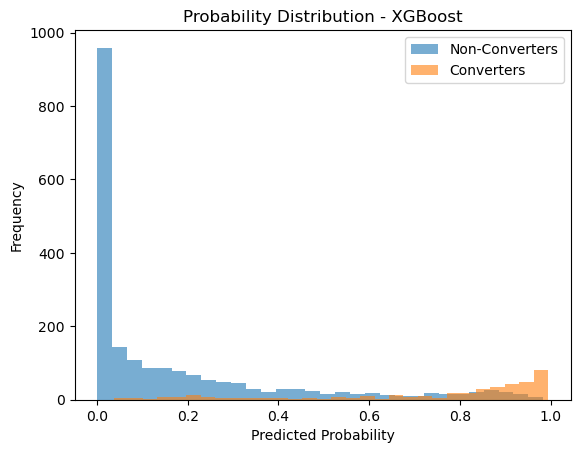

In [35]:
# Separate probabilities by class
probs_true = y_test_proba_xgb[y_test == 1]
probs_false = y_test_proba_xgb[y_test == 0]

plt.figure()
plt.hist(probs_false, bins=30, alpha=0.6, label="Non-Converters")
plt.hist(probs_true, bins=30, alpha=0.6, label="Converters")

plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")
plt.title("Probability Distribution - XGBoost")
plt.legend()
plt.show()

- Many non-converters are near 0 and converters are near 1, which is good.

- There is also some overlap ~ 0.2 - 0.6, makes sense because perfect separation is unrealistic.

### New Probability Threshold - 1

In [36]:
threshold = 0.35

y_pred_xgb_new = (y_test_proba_xgb >= threshold).astype(int)

## Evaluation

### Accuracy

In [37]:
accuracy_xgb_new = accuracy_score(y_test, y_pred_xgb_new)
print("Accuracy (Test):", accuracy_xgb_new)

Accuracy (Test): 0.8313057583130575


### Classification Report

In [38]:
print("Confusion Matrix (Threshold = 0.35)")
print(confusion_matrix(y_test, y_pred_xgb_new))

print("\nClassification Report (Threshold = 0.35)")
print(classification_report(y_test, y_pred_xgb_new))

Confusion Matrix (Threshold = 0.35)
[[1698  357]
 [  59  352]]

Classification Report (Threshold = 0.35)
              precision    recall  f1-score   support

       False       0.97      0.83      0.89      2055
        True       0.50      0.86      0.63       411

    accuracy                           0.83      2466
   macro avg       0.73      0.84      0.76      2466
weighted avg       0.89      0.83      0.85      2466



### New Probability Threshold - 2

In [39]:
threshold = 0.25

y_pred_xgb_new2 = (y_test_proba_xgb >= threshold).astype(int)

## Evaluation

### Accuracy

In [40]:
accuracy_xgb_new2 = accuracy_score(y_test, y_pred_xgb_new2)
print("Accuracy (Test):", accuracy_xgb_new2)

Accuracy (Test): 0.7846715328467153


### Classification Report

In [41]:
print("Confusion Matrix (Threshold = 0.25)")
print(confusion_matrix(y_test, y_pred_xgb_new2))

print("\nClassification Report (Threshold = 0.25)")
print(classification_report(y_test, y_pred_xgb_new2))

Confusion Matrix (Threshold = 0.25)
[[1570  485]
 [  46  365]]

Classification Report (Threshold = 0.25)
              precision    recall  f1-score   support

       False       0.97      0.76      0.86      2055
        True       0.43      0.89      0.58       411

    accuracy                           0.78      2466
   macro avg       0.70      0.83      0.72      2466
weighted avg       0.88      0.78      0.81      2466



# Feature Importance / Selection

## Experiment - 1 - Check if 'page_value' column is target encoding

In [42]:
X_train_pv = X_train[["page_value"]]
X_test_pv  = X_test[["page_value"]]

In [43]:
#Logistic Regression
lr_pv = LogisticRegression(class_weight="balanced", max_iter=5000)
lr_pv.fit(X_train_pv, y_train)

y_pred_pv = lr_pv.predict(X_test_pv)

y_train_proba_pv = lr_pv.predict_proba(X_train_pv)[:, 1]
y_test_proba_pv  = lr_pv.predict_proba(X_test_pv)[:, 1]

### Evaluation

In [44]:
print("Accuracy:", accuracy_score(y_test, y_pred_pv))
print(confusion_matrix(y_test, y_pred_pv))
print(classification_report(y_test, y_pred_pv))

Accuracy: 0.8819951338199513
[[1898  157]
 [ 134  277]]
              precision    recall  f1-score   support

       False       0.93      0.92      0.93      2055
        True       0.64      0.67      0.66       411

    accuracy                           0.88      2466
   macro avg       0.79      0.80      0.79      2466
weighted avg       0.88      0.88      0.88      2466



In [45]:
roc_train_pv = roc_auc_score(y_train, y_train_proba_pv)
roc_test_pv  = roc_auc_score(y_test, y_test_proba_pv)

print("ROC AUC (Train):", roc_train_pv)
print("ROC AUC (Test):", roc_test_pv)

ROC AUC (Train): 0.8639601421080478
ROC AUC (Test): 0.86068458036597


In [46]:
from sklearn.metrics import average_precision_score

pr_train_pv = average_precision_score(y_train, y_train_proba_pv)
pr_test_pv  = average_precision_score(y_test, y_test_proba_pv)

print("PR AUC (Train):", pr_train_pv)
print("PR AUC (Test):", pr_test_pv)

PR AUC (Train): 0.6189232944725854
PR AUC (Test): 0.6279375111010292


- Does not indicate a leak / target encoding since the AUC values are not too closer to 1

## Experiment - 2 - Drop page_value column

In [47]:
X_train_no_pv = X_train.drop(columns=["page_value"])
X_test_no_pv  = X_test.drop(columns=["page_value"])

### Random Forest

In [71]:
rf_no_pv = RandomForestClassifier(
    n_estimators=200,
    class_weight="balanced",
    random_state=42
)

rf_no_pv.fit(X_train_no_pv, y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=200,
                       random_state=42)

In [73]:
y_pred_rf_no_pv = rf_no_pv.predict(X_test_no_pv)

y_train_proba_rf_no_pv = rf_no_pv.predict_proba(X_train_no_pv)[:, 1]
y_test_proba_rf_no_pv  = rf_no_pv.predict_proba(X_test_no_pv)[:, 1]

## Evaluation 

### Accuracy

In [74]:
accuracy_rf = accuracy_score(y_test, y_pred_rf_no_pv)
print("Accuracy:", accuracy_rf)


Accuracy: 0.8357664233576643


### Classification Report

In [75]:
print(confusion_matrix(y_test, y_pred_rf_no_pv))
print(classification_report(y_test, y_pred_rf_no_pv))

[[2035   20]
 [ 385   26]]
              precision    recall  f1-score   support

       False       0.84      0.99      0.91      2055
        True       0.57      0.06      0.11       411

    accuracy                           0.84      2466
   macro avg       0.70      0.53      0.51      2466
weighted avg       0.79      0.84      0.78      2466



### ROC AUC

In [78]:
print("ROC AUC - Train:", roc_auc_score(y_train, y_train_proba_rf_no_pv))
print("ROC AUC - Test :", roc_auc_score(y_test, y_test_proba_rf_no_pv))

ROC AUC - Train: 1.0
ROC AUC - Test : 0.7665322843222571


### PR AUC

In [79]:
print("PR AUC - Train:", average_precision_score(y_train, y_train_proba_rf_no_pv))
print("PR AUC - Test :", average_precision_score(y_test, y_test_proba_rf_no_pv))

PR AUC - Train: 1.0
PR AUC - Test : 0.3796238576791255


## Experiment - 3 - Dropping bottom 25% features, importance wise

### Random Forest

In [61]:
rf = RandomForestClassifier(
    n_estimators=200,
    class_weight="balanced",
    random_state=42
)
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=200,
                       random_state=42)

In [62]:
importances = pd.Series(
    rf.feature_importances_,
    index=X_train.columns
)

low_features = importances.sort_values().head(int(len(importances)*0.25)).index # drop bottom 25% features

X_train_drop = X_train.drop(columns=low_features)
X_test_drop  = X_test.drop(columns=low_features)

print("Dropped", len(low_features), "features")

Dropped 18 features


In [63]:
rf_drop = RandomForestClassifier(
    n_estimators=200,
    class_weight="balanced",
    random_state=42
)

rf_drop.fit(X_train_drop, y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=200,
                       random_state=42)

In [64]:
y_pred_rf_drop = rf_drop.predict(X_test_drop)

y_train_proba_rf_drop = rf_drop.predict_proba(X_train_drop)[:, 1]
y_test_proba_rf_drop  = rf_drop.predict_proba(X_test_drop)[:, 1]

## Evaluation 

### Accuracy

In [81]:
accuracy_rf = accuracy_score(y_test, y_pred_rf_drop)
print("Accuracy:", accuracy_rf)


Accuracy: 0.8884833738848338


### Classification Report

In [69]:
print(confusion_matrix(y_test, y_pred_rf_drop))
print(classification_report(y_test, y_pred_rf_drop))

[[1991   64]
 [ 211  200]]
              precision    recall  f1-score   support

       False       0.90      0.97      0.94      2055
        True       0.76      0.49      0.59       411

    accuracy                           0.89      2466
   macro avg       0.83      0.73      0.76      2466
weighted avg       0.88      0.89      0.88      2466



### ROC AUC

In [67]:
print("ROC AUC - Train:", roc_auc_score(y_train, y_train_proba_rf_drop))
print("ROC AUC - Test :", roc_auc_score(y_test, y_test_proba_rf_drop))

ROC AUC - Train: 0.9999999999999999
ROC AUC - Test : 0.9201253840552686


### PR AUC

In [68]:
print("PR AUC - Train:", average_precision_score(y_train, y_train_proba_rf_drop))
print("PR AUC - Test :", average_precision_score(y_test, y_test_proba_rf_drop))

PR AUC - Train: 0.9999999999999999
PR AUC - Test : 0.7358722160132118


## Experiment - 4 - Hyperparameter tuning

### Random Forest - to reduce overfitting

In [ ]:
param_grid = {
    "max_depth": [5, 10, 20, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 3, 5],
    "max_features": ["sqrt", "log2"]
}

rf = RandomForestClassifier(
    n_estimators=200,
    class_weight="balanced",
    random_state=42
)

grid_rf = GridSearchCV(
    rf,
    param_grid,
    scoring="average_precision",   #for imbalance
    cv=5,
    n_jobs=-1
)

grid_rf.fit(X_train, y_train)

print("Best parameters:", grid_rf.best_params_)
print("Best CV PR AUC:", grid_rf.best_score_)

Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5}
Best CV PR AUC: 0.7385516097494584


Exception ignored in: <function ResourceTracker.__del__ at 0x104c55bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x103079bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x104f41bc0>
Traceback (most recent call last

In [84]:
best_rf = grid_rf.best_estimator_

## Evaluation 

In [85]:
# Predictions
y_pred_best_rf = best_rf.predict(X_test)
y_train_proba_best_rf = best_rf.predict_proba(X_train)[:, 1]
y_test_proba_best_rf  = best_rf.predict_proba(X_test)[:, 1]

# Accuracy + report
print("Accuracy:", accuracy_score(y_test, y_pred_best_rf))
print(confusion_matrix(y_test, y_pred_best_rf))
print(classification_report(y_test, y_pred_best_rf))

# ROC AUC
print("ROC AUC (Train):", roc_auc_score(y_train, y_train_proba_best_rf))
print("ROC AUC (Test):", roc_auc_score(y_test, y_test_proba_best_rf))

# PR AUC
print("PR AUC (Train):", average_precision_score(y_train, y_train_proba_best_rf))
print("PR AUC (Test):", average_precision_score(y_test, y_test_proba_best_rf))

Accuracy: 0.8876723438767234
[[1956   99]
 [ 178  233]]
              precision    recall  f1-score   support

       False       0.92      0.95      0.93      2055
        True       0.70      0.57      0.63       411

    accuracy                           0.89      2466
   macro avg       0.81      0.76      0.78      2466
weighted avg       0.88      0.89      0.88      2466

ROC AUC (Train): 0.9998835166847778
ROC AUC (Test): 0.9208020317189691
PR AUC (Train): 0.9993365039850068
PR AUC (Test): 0.7292033020144127


## Experiment - 5 - SMOTE

In [88]:
smote = SMOTE(random_state=42)

X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

print("Before SMOTE:")
print(pd.Series(y_train).value_counts())

print("\nAfter SMOTE:")
print(pd.Series(y_train_sm).value_counts())

Before SMOTE:
False    8367
True     1497
Name: count, dtype: int64

After SMOTE:
False    8367
True     8367
Name: count, dtype: int64


### Logistic Regression with SMOTE and without class weight balanced

In [89]:
lr_sm = LogisticRegression(max_iter=5000)

lr_sm.fit(X_train_sm, y_train_sm)

/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=5000)

In [90]:
y_pred_lr_sm = lr_sm.predict(X_test)

y_train_proba_lr_sm = lr_sm.predict_proba(X_train_sm)[:, 1]
y_test_proba_lr_sm  = lr_sm.predict_proba(X_test)[:, 1]

### Evaluation 

In [91]:
print("Accuracy:", accuracy_score(y_test, y_pred_lr_sm))
print(confusion_matrix(y_test, y_pred_lr_sm))
print(classification_report(y_test, y_pred_lr_sm))

print("ROC AUC - Train:", roc_auc_score(y_train_sm, y_train_proba_lr_sm))
print("ROC AUC - Test :", roc_auc_score(y_test, y_test_proba_lr_sm))

print("PR AUC - Train:", average_precision_score(y_train_sm, y_train_proba_lr_sm))
print("PR AUC - Test :", average_precision_score(y_test, y_test_proba_lr_sm))

Accuracy: 0.8613138686131386
[[1825  230]
 [ 112  299]]
              precision    recall  f1-score   support

       False       0.94      0.89      0.91      2055
        True       0.57      0.73      0.64       411

    accuracy                           0.86      2466
   macro avg       0.75      0.81      0.78      2466
weighted avg       0.88      0.86      0.87      2466

ROC AUC - Train: 0.9267789967898639
ROC AUC - Test : 0.8978522504602744
PR AUC - Train: 0.9120451155510009
PR AUC - Test : 0.6579305071373766


## Experiment - 6 - Scale POS weight  - XGBoost

In [92]:
neg = np.sum(y_train == 0)
pos = np.sum(y_train == 1)
base_spw = neg / pos

print("neg:", neg, "pos:", pos, "base scale_pos_weight:", base_spw)

neg: 8367 pos: 1497 base scale_pos_weight: 5.589178356713427


In [94]:
spw_grid = [3, 4, 5, 5.6, 6, 7, 8]

for spw in spw_grid:
    
    print("\n" + "="*60)
    print(f"scale_pos_weight = {spw}")
    print("="*60)
    
    # Initialize model
    xgb_spw = XGBClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=spw,
        random_state=42,
        eval_metric="logloss"
    )

    # Train
    xgb_spw.fit(X_train, y_train)

    # Predictions
    y_pred_test = xgb_spw.predict(X_test)
    y_pred_train = xgb_spw.predict(X_train)

    y_proba_test = xgb_spw.predict_proba(X_test)[:, 1]
    y_proba_train = xgb_spw.predict_proba(X_train)[:, 1]

    # Accuracy
    print("Accuracy (Test):", accuracy_score(y_test, y_pred_test))

    # Confusion Matrix
    print("\nConfusion Matrix (Test):")
    print(confusion_matrix(y_test, y_pred_test))

    # Classification Report
    print("\nClassification Report (Test):")
    print(classification_report(y_test, y_pred_test))

    # ROC AUC
    print("ROC AUC (Train):", roc_auc_score(y_train, y_proba_train))
    print("ROC AUC (Test) :", roc_auc_score(y_test, y_proba_test))

    # PR AUC
    print("PR AUC (Train):", average_precision_score(y_train, y_proba_train))
    print("PR AUC (Test) :", average_precision_score(y_test, y_proba_test))


scale_pos_weight = 3
Accuracy (Test): 0.8852392538523925

Confusion Matrix (Test):
[[1880  175]
 [ 108  303]]

Classification Report (Test):
              precision    recall  f1-score   support

       False       0.95      0.91      0.93      2055
        True       0.63      0.74      0.68       411

    accuracy                           0.89      2466
   macro avg       0.79      0.83      0.81      2466
weighted avg       0.89      0.89      0.89      2466

ROC AUC (Train): 0.9704494044461179
ROC AUC (Test) : 0.9295126124046151
PR AUC (Train): 0.8649011673145329
PR AUC (Test) : 0.7567562128460864

scale_pos_weight = 4
Accuracy (Test): 0.8811841038118411

Confusion Matrix (Test):
[[1854  201]
 [  92  319]]

Classification Report (Test):
              precision    recall  f1-score   support

       False       0.95      0.90      0.93      2055
        True       0.61      0.78      0.69       411

    accuracy                           0.88      2466
   macro avg       0.78      